# Obs overturning vs model overturning

In [1]:
%matplotlib inline

import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob
import cmocean.cm as cmocean
from gsw import SA_from_SP, p_from_z, sigma1, CT_from_t, sigma0, sigma4
import xgcm
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)
import cartopy.crs as ccrs

from dask.distributed import Client

In [3]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:41587 Dashboard: /proxy/45447/status,Cluster Workers: 4 Cores: 16 Memory: 64.00 GiB


### residual overturning streamfunction

In [18]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
g = 9.81

# trying to compare potrho0 and potrho4:
1. save salt,temp, tytrans 10 years
2. save pot_rho_0 and pot_rho_4

code:

    st_ocean = cc.querying.getvar(expt,'st_ocean',session,n=1)
    depth = xr.zeros_like(salt) -salt.st_ocean
    lat = xr.zeros_like(salt) + salt.yt_ocean
    lon = xr.zeros_like(salt) + salt.xt_ocean

    pressure = p_from_z(depth,lat)

    # absolute salinity model:
    abs_salt = SA_from_SP(salt,pressure,lon,lat)
    sigma_0 = sigma0(abs_salt,temp-273.15)
    sigma_4 = sigma4(abs_salt,temp-273.15)
    save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
    ds = xr.Dataset({'sigma_0':sigma_0,'sigma_4':sigma_4})
    ds.to_netcdf(save_dir+'sigma0sigma4_10yr_unweightedmonth.nc')

In [19]:
salt = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/salttempvhrho_10yr_unweightedmonth.nc').salt
temp = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/salttempvhrho_10yr_unweightedmonth.nc').temp
ty_trans = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/salttempvhrho_10yr_unweightedmonth.nc').ty_trans

In [20]:
rho = 1025 # mean density of sea-water in kg/m^3
ty_trans = ty_trans / (1e6*rho)

In [21]:
sigma_0 = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/sigma0sigma4_10yr_unweightedmonth.nc').sigma_0
sigma_2 = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/pot_rho_2_10yr.nc').pot_rho_2-1000
sigma_4 = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/sigma0sigma4_10yr_unweightedmonth.nc').sigma_4


In [22]:
ty_trans = ty_trans.interp({'yu_ocean':sigma_0.yt_ocean.values})
ty_trans = ty_trans.rename({'yu_ocean':'yt_ocean'})

### Talley 2008 density bins

find ty_trans in model density bins


In [23]:
bool_list = [(sigma_0<26.4),(sigma_0>26.4)&(sigma_0<27.1),(sigma_0>27.1)&(sigma_0<27.4),
            (sigma_0>27.4)&(sigma_2<36.8),(sigma_2>36.8)&(sigma_4<45.8),
            (sigma_4>45.8)&(sigma_4<45.86),(sigma_4>45.86)]
bool_list_name = ['(sigma_0<26.4)','(sigma_0>26.4)&(sigma_0<27.1)','(sigma_0>27.1)&(sigma_0<27.4)',
            '(sigma_0>27.4)&(sigma_2<36.8)','(sigma_2>36.8)&(sigma_4<45.8)',
            '(sigma_4>45.8)&(sigma_4<45.86)','(sigma_4>45.86)']


In [73]:
plt.rc('text', usetex=False)
plt.rcParams.update({'font.size': 12})


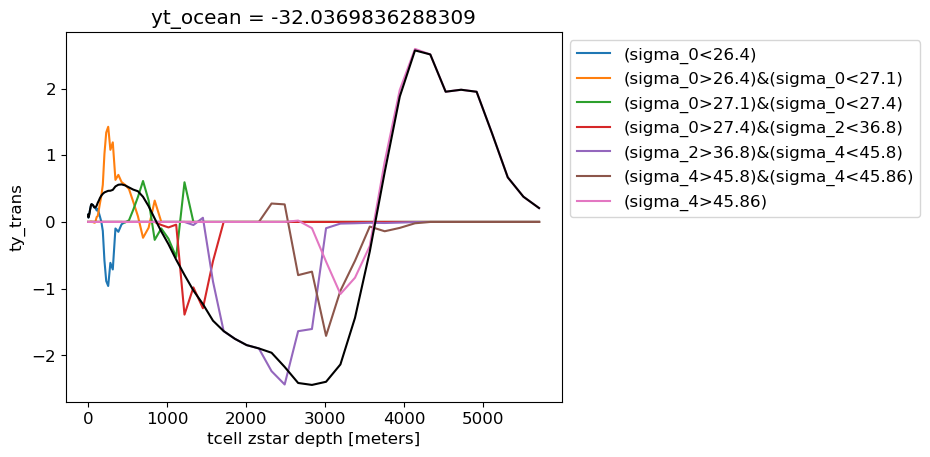

In [29]:
model = np.zeros(7)
trans = np.zeros(75)
for i in np.arange(7):
    trans_1 = ty_trans.where(bool_list[i]).sel(yt_ocean = -32, method = 'nearest').sum('xt_ocean')
    trans_1.plot(label = bool_list_name[i])
    model[i] = trans_1.sum('st_ocean').values
    trans = trans+trans_1
ty_trans.sel(yt_ocean = -32, method = 'nearest').sum('xt_ocean').plot(color = 'k')
#trans.plot()
plt.legend(bbox_to_anchor = (1,1))

In [30]:
obs = [-9.24,12.08,-5.86,-10.02,-11.11,-2.84,26.01]
obs1 = [3.3,4.3,-7.17,-16.05,-22.3,-2.36,48]
obs2 = [-9,11.8,-5.9,-10.1,-11.4,-2.9,27.3]

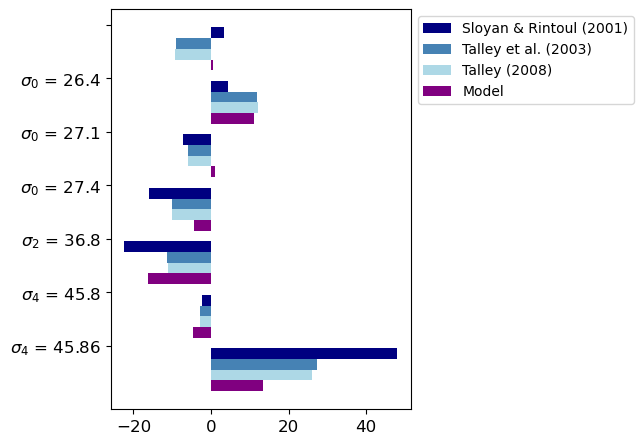

In [32]:
X = np.arange(7)
fig = plt.figure(figsize = (3,4))
ax = fig.add_axes([0,0,1,1])
ax.barh(X + 0.00,obs1,  0.2,color = 'navy',  label = 'Sloyan & Rintoul (2001)')
ax.barh( X + 0.2, obs2,0.2,color = 'steelblue',  label = 'Talley et al. (2003)')
ax.barh(X + 0.4, obs, 0.2,color = 'lightblue',  label = 'Talley (2008)')
ax.barh(X + 0.6,model, 0.2,color = 'purple',  label ='Model')

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_yticks(X-0.15)
#ax.set_yticks(X)
ax.set_yticklabels(['','$\sigma_0$ = 26.4','$\sigma_0$ = 27.1','$\sigma_0$ = 27.4',
                   '$\sigma_2$ = 36.8','$\sigma_4$ = 45.8','$\sigma_4$ = 45.86'], rotation = 0);

plt.legend(fontsize = 10, bbox_to_anchor=(1,1))


psi_avg from

        psi = cc.querying.getvar(expt,'ty_trans_rho',session,start_time='2170-01-01', end_time='2179-12-31')
        psi
        psi = psi.sel(time=slice('2170-01-01','2179-12-31'))
        rho = 1025 # mean density of sea-water in kg/m^3
        psi = psi / (1e6*rho) # converts kg/s to Sv
        psi = psi.mean('time')
        psi.load()
        save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
        ds = xr.Dataset({'ty_trans_rho': psi})
        ds.to_netcdf(save_dir+'ty_trans_rho_10yr.nc')

        psi_avg = psi.cumsum('st_ocean').mean('time') - psi.sum('st_ocean').mean('time')
        psi_avg.load()
        psi_avg = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/psi_avg_10yr.nc').psi_avg
        psi_avg = psi_avg.load()

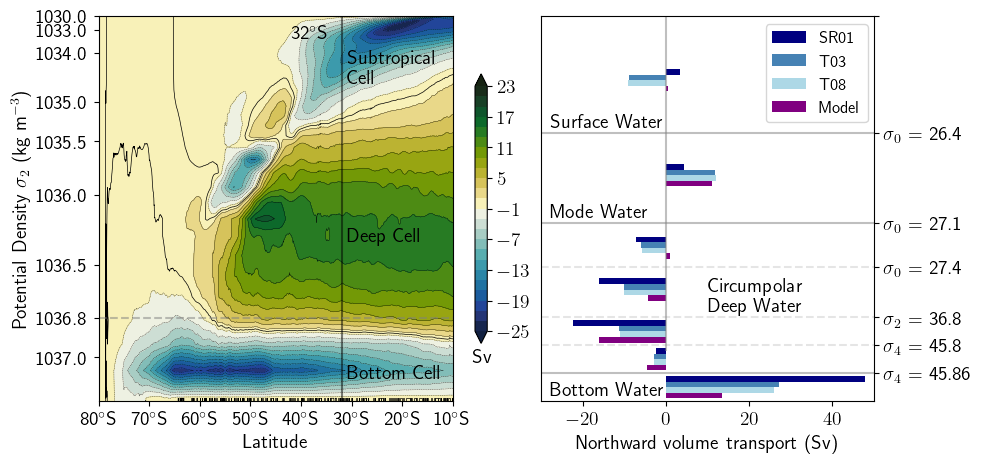

In [87]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1.5]}, figsize = (10,5))
X = np.array([1,2.7,4.0,4.75,5.5,6,6.5])
ax1.barh(X + 0.00,obs1,  0.1,color = 'navy',  label = 'SR01')
ax1.barh( X + 0.1, obs2,0.1,color = 'steelblue',  label = 'T03')
ax1.barh(X + 0.2, obs, 0.1,color = 'lightblue',  label = 'T08')
ax1.barh(X + 0.3,model, 0.1,color = 'purple',  label ='Model')
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_yticks([0,2.1,3.7,4.5,5.4,5.9,6.4])
#ax.set_yticks(X)
ax1.yaxis.tick_right()
ax1.set_ylim(6.9,0)
ax1.set_yticklabels(['','$\sigma_0$ = 26.4','$\sigma_0$ = 27.1','$\sigma_0$ = 27.4',
                   '$\sigma_2$ = 36.8','$\sigma_4$ = 45.8','$\sigma_4$ = 45.86'], rotation = 0);

ax1.legend(fontsize = 12, bbox_to_anchor=(0.65,1))
ax1.vlines(0,0,6, color = 'grey', alpha = 0.5)
ax1.hlines([2.1,3.7,6.4],-30,50, color = 'grey', alpha = 0.5)
ax1.hlines([4.5,5.4,5.9],-30,50, color = 'grey', alpha = 0.2, linestyle = '--')

ax1.text(-28,2,'Surface Water')
ax1.text(-28,3.6,'Mode Water')
ax1.text(10,5.3,'Circumpolar \nDeep Water')
ax1.text(-28,6.8,'Bottom Water')
ax1.set_xlabel('Northward volume transport (Sv)')
ax1.set_xlim(-30,50)
clev = np.arange(-25,25,2)
yticks = np.array([1030, 1033, 1034, 1035, 1035.5,1036,1036.5, 1036.8,1037])
scfac = 5.5  ## A power to set teh stretching
p1=ax0.contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, cmap='cmo.delta', levels=clev, extend='both')
cb=fig.colorbar(p1, ax = ax0,orientation='vertical', shrink = 0.7)
cb.ax.set_xlabel('Sv')
ax0.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=clev, colors='k', linewidths=0.25)
ax0.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
ax0.vlines(-32,20,9.2**scfac,color = 'k', alpha = 0.5)
ax0.text(-42,5.5**scfac,'32$^\circ$S')
ax0.text(-31,9.1**scfac,'Bottom Cell')
ax0.text(-31,8.35**scfac,'Deep Cell')
ax0.text(-31,6.7**scfac,'Subtropical \nCell')

ax0.set_yticks((yticks-1028)**scfac)
ax0.set_yticklabels(yticks)
ax0.set_ylim([0.5**scfac, 9.2**scfac])
ax0.invert_yaxis()
ax0.set_ylabel('Potential Density $\sigma_2$ (kg m$^{-3}$)')
ax0.set_xlabel('Latitude')
ax0.set_xlim([-80,-10])
X = np.arange(-80,-9,10)
ax0.set_xticks(X)
ax0.set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S','20$^\circ$S', '10$^\circ$S'));
ax0.hlines(8.8**scfac,-80,-10, linestyle = '--', color = 'grey', alpha = 0.5)
plt.subplots_adjust(wspace = 0)
plt.savefig('obsobverturningalternative.png',dpi = 400)

# In depth coordinates instead:

In [33]:
ty_trans_rho_z = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/ty_trans_rho_z_10yr_high_res_zonal_mean.nc').ty_trans_rho_z
#ty_trans_rho_z = ty_trans_rho_z.interp({'z_bins':np.arange(0,4500,100)}, method = 'linear')
def cumsum_from_bottom_z (residual):
    cumsum= (residual.cumsum('z_bins')-residual.sum('z_bins'))
    return cumsum
psi_avg = cumsum_from_bottom_z(ty_trans_rho_z)/1e6*10 # because i divided by 3650 not 365

In [85]:
plt.rc('text', usetex=True)
plt.rcParams.update({'font.size': 14})

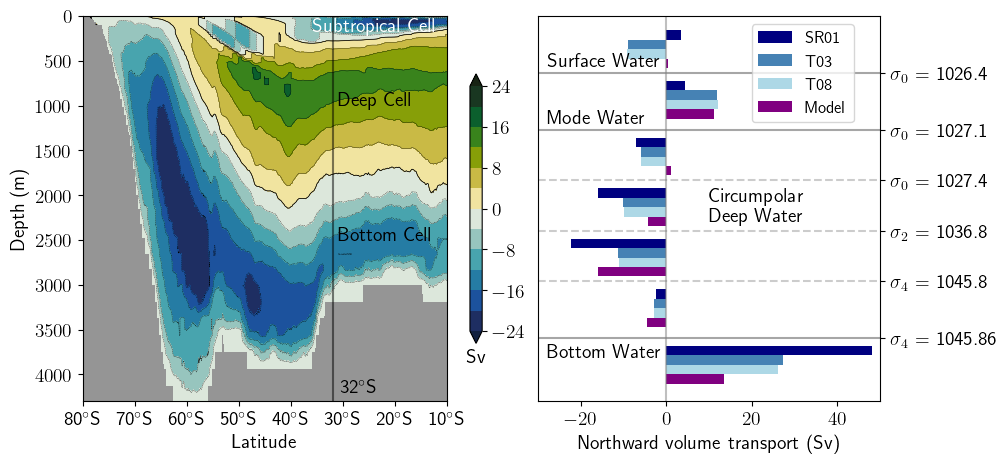

In [86]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1.5]}, figsize = (11,5))
X = np.array([1,1.8,2.7,3.5,4.3,5.1,6])
ax1.barh(X + 0.00,obs1,  0.15,color = 'navy',  label = 'SR01')
ax1.barh( X + 0.15, obs2,0.15,color = 'steelblue',  label = 'T03')
ax1.barh(X + 0.3, obs, 0.15,color = 'lightblue',  label = 'T08')
ax1.barh(X + 0.45,model, 0.15,color = 'purple',  label ='Model')
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.set_yticks([0,1.6,2.5,3.3,4.1,4.9,5.8])
#ax.set_yticks(X)
ax1.yaxis.tick_right()
ax1.set_ylim(6.8,0.7)
ax1.set_yticklabels(['','$\sigma_0$ = 1026.4','$\sigma_0$ = 1027.1','$\sigma_0$ = 1027.4',
                   '$\sigma_2$ = 1036.8','$\sigma_4$ = 1045.8','$\sigma_4$ = 1045.86'], rotation = 0);

ax1.legend(fontsize = 12, bbox_to_anchor=(0.6,1))
ax1.vlines(0,0,6.8, color = 'grey', alpha = 0.5)
ax1.hlines([1.6,2.5,5.8],-30,50, color = 'grey', alpha = 0.7)
ax1.hlines([3.3,4.1,4.9],-30,50, color = 'grey', alpha = 0.4, linestyle = '--')

ax1.text(-28,1.5,'Surface Water')
ax1.text(-28,2.4,'Mode Water')
ax1.text(10,3.95,'Circumpolar \nDeep Water')
ax1.text(-28,6.1,'Bottom Water')
ax1.set_xlabel('Northward volume transport (Sv)')
ax1.set_xlim(-30,50)
clev = np.arange(-24,25,4)
p1=ax0.contourf(psi_avg.grid_yu_ocean,psi_avg.z_bins, psi_avg, cmap='cmo.delta', levels=clev, extend='both')
cb=fig.colorbar(p1, ax = ax0,orientation='vertical', shrink = 0.7)
cb.ax.set_xlabel('Sv')

ax0.contour(psi_avg.grid_yu_ocean,psi_avg.z_bins, psi_avg, levels=clev, colors='k', linewidths=0.25)
ax0.contour(psi_avg.grid_yu_ocean,psi_avg.z_bins, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
ax0.contourf(psi_avg.grid_yu_ocean,psi_avg.z_bins, psi_avg.where(psi_avg==0)*0+1,cmap = 'Greys', add_colorbar = False, levels = [0,1])
ax0.text(-30.5,4200,'32$^\circ$S')
ax0.vlines(-32,0,4500,color = 'k', alpha = 0.5)
ax0.text(-31,2500,'Bottom Cell')
ax0.text(-31,1000,'Deep Cell')
ax0.text(-36,170,'Subtropical Cell', color = 'w')

ax0.invert_yaxis()
ax0.set_ylabel('Depth (m)')
ax0.set_xlabel('Latitude')
ax0.set_xlim([-80,-10])
X = np.arange(-80,-9,10)
ax0.set_xticks(X)
ax0.set_xticklabels(('80$^\circ$S','70$^\circ$S','60$^\circ$S','50$^\circ$S','40$^\circ$S','30$^\circ$S','20$^\circ$S', '10$^\circ$S'));
plt.subplots_adjust(wspace = 0, right = 0.85)
ax0.set_ylim(4300,0)
plt.savefig('obsobverturningdepth.png',dpi = 400)

# Bin meridional transport into density bins
(same as binning code in Analysis section, but for more bins to get more resolution of bottom water)

then take time average so that residual overturning is calculated

then bin into depth coordinates using zonal average layer thicknesses (makes it smoother, just a visual transformation)

In [5]:
lat_range = slice(-80,10)
lat_range_big =  slice(-80.05,10.1)

dyt = cc.querying.getvar(expt,'dyt',session,ncfile = 'ocean_grid.nc',n=1)
dyt = dyt.sel(yt_ocean = lat_range)
dxt = cc.querying.getvar(expt,'dxt',session,ncfile = 'ocean_grid.nc',n=1)
dxt = dxt.sel(yt_ocean = lat_range)


(1032.6, 1031.0)

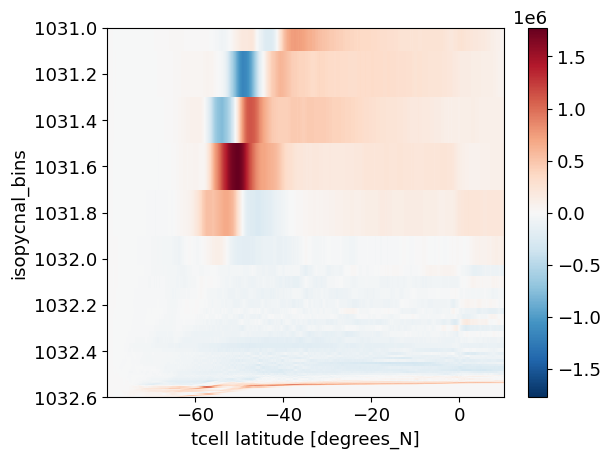

In [10]:
vh = xr.open_dataset('/g/data/x77/cy8964/Post_Process/Big_SO/vh_bar_sum_2170_big.nc').vh_bar_sum
ty_trans_rho = vh/3650/rho_0*dxt
ty_trans_rho.sum('xt_ocean').plot()
plt.ylim(1032.6,1031)

(1032.6, 1030.0)

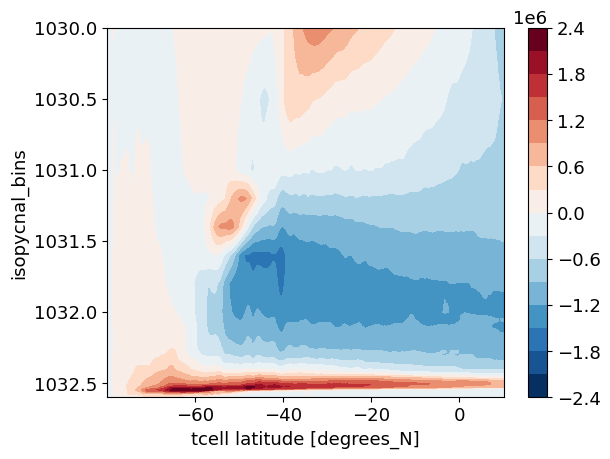

In [13]:
psi_avg = ty_trans_rho.sum('xt_ocean').sum('isopycnal_bins')-ty_trans_rho.sum('xt_ocean').cumsum('isopycnal_bins')
psi_avg.plot.contourf(levels = 20, y = 'isopycnal_bins')
plt.ylim(1032.6,1030)

In [14]:
rho0 = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_pot_rho_1_10_yr_mean_big.nc').pot_rho_1
rho0


<xarray.DataArray 'pot_rho_1' (st_ocean: 75, yt_ocean: 1319, xt_ocean: 3600)>
[356130000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 -79.84 ... 9.802 9.9 9.999
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03

In [15]:
rho0_bins = ty_trans_rho.isopycnal_bins.values
st_edges_ocean = cc.querying.getvar('01deg_jra55v13_ryf9091','st_edges_ocean',session,n=1)
thickness = st_edges_ocean.diff('st_edges_ocean')
# overwrite coord:
thickness.coords['st_edges_ocean'] = rho0['st_ocean'].values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
# make array:
thickness_array = rho0[0,...]*0 + thickness
thickness_array = thickness_array.load()

# I can't get this to work with thickness_binned as an xarray, just convert after:
thickness_binned = np.zeros((len(rho0_bins),len(rho0.yt_ocean),len(rho0.xt_ocean)))


In [16]:
for i in range(len(rho0_bins)-1):
    print(i)
    bin_mask = rho0.where(rho0<=rho0_bins[i+1]).where(rho0>rho0_bins[i])*0+1
    bin_fractions = (rho0_bins[i+1]-rho0 * bin_mask)/(rho0_bins[i+1]-rho0_bins[i])
    ## bin thickness:
    thickness_in_lower_bin = (thickness_array * bin_mask * bin_fractions).sum(dim = 'st_ocean')
    thickness_binned[i,:,:] += thickness_in_lower_bin.fillna(0).values
    del thickness_in_lower_bin
    thickness_in_upper_bin = (thickness_array * bin_mask * (1-bin_fractions)).sum(dim = 'st_ocean')
    thickness_binned[i+1,:,:] += thickness_in_upper_bin.fillna(0).values
    del thickness_in_upper_bin


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61


In [17]:
thickness_binned = xr.DataArray(thickness_binned, 
                             coords = [rho0_bins,rho0.yt_ocean,rho0.xt_ocean], 
                             dims = ['potrho', 'yt_ocean','grid_xt_ocean'], 
                             name = 'thickness_binned')

In [19]:
thickness_binned = thickness_binned#.interp({'yt_ocean':ty_trans_rho.grid_yu_ocean})

In [20]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'

ds_vol_trans_across_contour_binned = xr.Dataset({'thickness_binned': thickness_binned})
ds_vol_trans_across_contour_binned.to_netcdf(save_dir+'pot_rho_1_thickness_binned_high_res.nc')


In [21]:
thickness_binned = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/pot_rho_1_thickness_binned_high_res.nc').thickness_binned
#thickness_binned.isel(grid_xt_ocean = 5).plot()

now bin ty_trans_rho and h_sigma2 into z levels

In [23]:
isopycnal_depths = thickness_binned.cumsum('potrho').mean('grid_xt_ocean')

In [24]:
ty_trans_rho = ty_trans_rho.sum('xt_ocean')

In [25]:
z_bins = cc.querying.getvar(expt,'st_ocean',session,n=1).values
#z_bins = z_bins[0::2]

In [27]:
ty_trans_rho_z = xr.DataArray(np.zeros((len(z_bins),len(ty_trans_rho.yt_ocean))), 
                                               coords = [z_bins, ty_trans_rho.yt_ocean], 
                                               dims = ['z_bins', 'grid_yu_ocean'], 
                                               name = 'ty_trans_rho_z')
# ty_trans_rho_z = xr.DataArray(np.zeros((len(z_bins),len(ty_trans_rho.grid_yu_ocean),len(ty_trans_rho.grid_xt_ocean))), 
#                                                coords = [z_bins, ty_trans_rho.grid_yu_ocean, ty_trans_rho.grid_xt_ocean], 
#                                                dims = ['z_bins', 'grid_yu_ocean','grid_xt_ocean'], 
#                                                name = 'ty_trans_rho_z')

In [32]:
isopycnal_depths = isopycnal_depths.rename({'potrho':'isopycnal_bins'})

In [34]:
for i in range(len(z_bins)-1):
    print(i)
    #create masks for isopycnal binnning, that are 1 where the density that day is between two bin values, and 0 elsewhere
    bin_mask = isopycnal_depths.where(isopycnal_depths<=z_bins[i+1]).where(isopycnal_depths>z_bins[i])*0+1
    # create a fractional value that splits the transport between each bin based on which bin it is closer to
    bin_fractions = (z_bins[i+1]-isopycnal_depths * bin_mask)/(z_bins[i+1]-z_bins[i])

    ## vh - splits transport between the two bins and saves into vh_binned array
    transport_across_contour_in_sigmalower_bin = ( ty_trans_rho * bin_mask * bin_fractions).sum(dim = 'isopycnal_bins').fillna(0)
    ty_trans_rho_z[i,:] += transport_across_contour_in_sigmalower_bin.values
    del transport_across_contour_in_sigmalower_bin
    transport_across_contour_in_sigmaupper_bin = ( ty_trans_rho * bin_mask * (1-bin_fractions)).sum(dim = 'isopycnal_bins')
    ty_trans_rho_z[i+1,:] += transport_across_contour_in_sigmaupper_bin.fillna(0).values
    del transport_across_contour_in_sigmaupper_bin


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73


In [35]:
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'

ds_vol_trans_across_contour_binned = xr.Dataset({'ty_trans_rho_z': ty_trans_rho_z})
ds_vol_trans_across_contour_binned.to_netcdf(save_dir+'ty_trans_rho_z_10yr_high_res_zonal_mean.nc')


Text(0, 0.5, '')

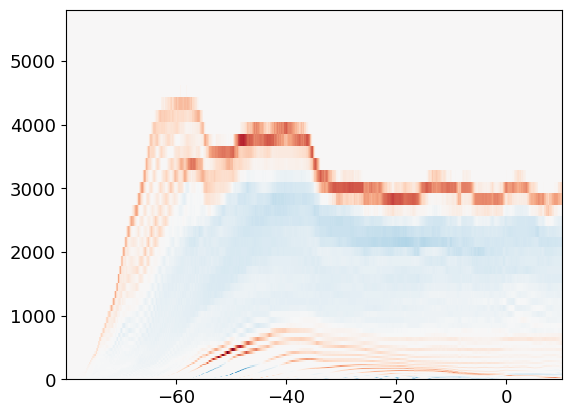

In [39]:
ty_trans_rho_z.plot(add_colorbar = False)
plt.title('')
plt.xlabel('')
plt.ylabel('')